# Example of how to read and parse the data file save from the rogue software

In [104]:
# Setup the library
import pyrogue.utilities.fileio as fileio
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from scipy.optimize import curve_fit
top_level=f'{os.getcwd()}/..'

# Waveforms variables to be filled
adcLive = { i : []  for i in range(4) }
ampLive = { i : []  for i in range(4) }  
adcFault = { i : []  for i in range(4) }
ampFault = { i : []  for i in range(4) }  

# Open the .dat file
with fileio.FileReader(files=f'{top_level}/data/ExampleData_3054MSPS_2GHzSignal.dat') as fd:
    
    # Loop through the file data
    for header,data in fd.records():

        # Convert the numpy array to 16-bit values
        rawData = data[16:].view(np.int16)
        
        # Check for error in frame
        if (header.error>0):
            # Look at record header data
            print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
            print(f"Record size    = {header.size}")
            print(f"Record channel = {header.channel}")
            print(f"Record flags   = {header.flags:#x}")
            print(f"Record error   = {header.error:#x}")

        # Check if ADC Live waveform
        elif header.channel < 4:
            adcLive[header.channel-0].append(rawData)

        # Check if AMP Live waveform
        elif header.channel < 8:
            ampLive[header.channel-4].append(rawData)        

        # Check if ADC Live waveform
        elif header.channel < 12:
            adcFault[header.channel-8].append(rawData)

        # Check if AMP Live waveform
        elif header.channel < 16:
            ampFault[header.channel-12].append(rawData)  
        
        # Else undefined stream index
        else:
            print('UNDEFINED DATA STREAM!!!')

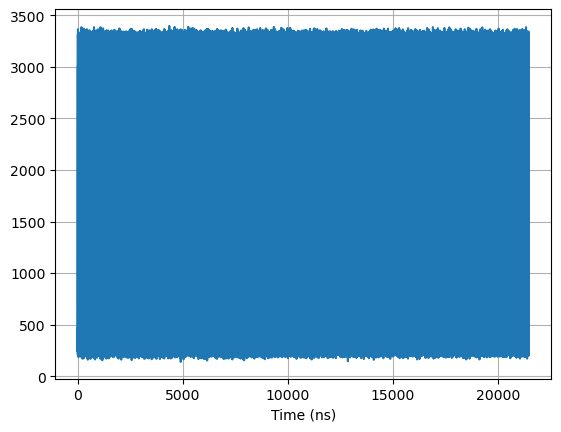

In [105]:
size = len(ampFault[2][1])
timeBin = 1.0/(0.509*6.0) # Unit of ns for 3.054 GSPS
timeSteps = np.linspace(0, timeBin*(size-1), num=size)

# Plot the Waveform Full Scale
plt.plot(timeSteps,ampFault[2][1])
plt.xlabel("Time (ns)")
plt.grid()

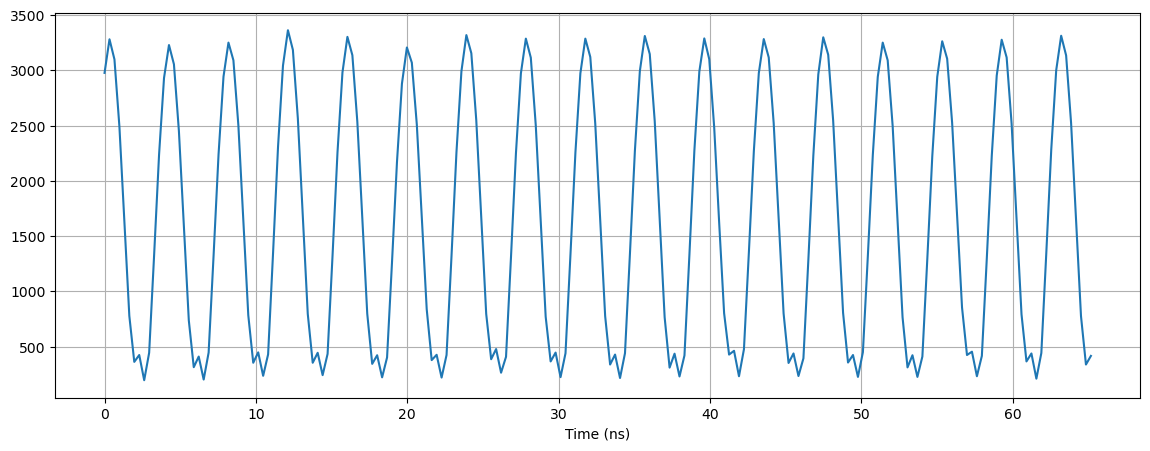

In [106]:
plt.figure(figsize=(14,5))
plt.plot(timeSteps[0:200],ampFault[3][7][0:200])
plt.xlabel("Time (ns)")
plt.grid()

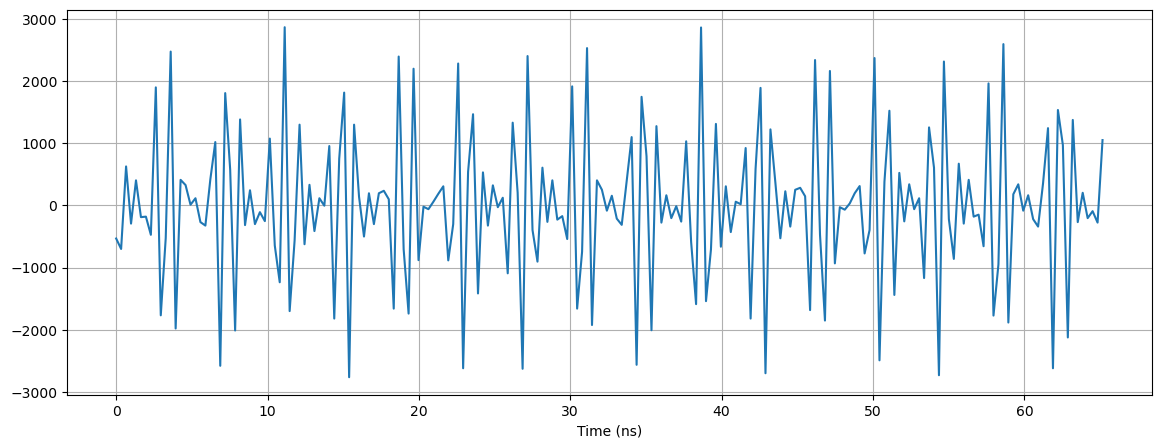

In [107]:
plt.figure(figsize=(14,5))
plt.plot(timeSteps[0:200],adcLive[3][1][0:200])
plt.xlabel("Time (ns)")
plt.grid()

In [236]:
#search peak and average
def peak_search(waveform_data,threshold):
    mountain_maxima = []
    peakave = []
    
    data_length = len(waveform_data)
    
    noise_threshold = threshold
    
    for i in range(3, data_length - 4):
        if waveform_data[i] > waveform_data[i - 1] and waveform_data[i] > waveform_data[i + 1]:
            candidate_peak = waveform_data[i]
            ave = waveform_data[i-3]/7+waveform_data[i-2]/7+waveform_data[i-1]/7+waveform_data[i]/7+waveform_data[i+1]/7+waveform_data[i+2]/7+waveform_data[i+3]/7
            if candidate_peak > noise_threshold:
                mountain_maxima.append(candidate_peak)
                peakave.append(ave)
    return mountain_maxima,peakave

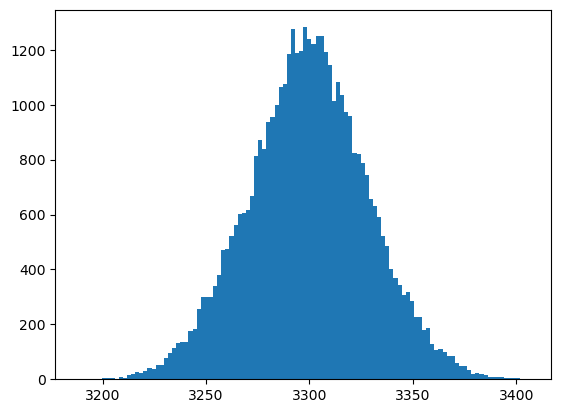

In [119]:
plt.hist(peak_search(np.concatenate(ampFault[2]),3000)[0],bins=110)
plt.show()

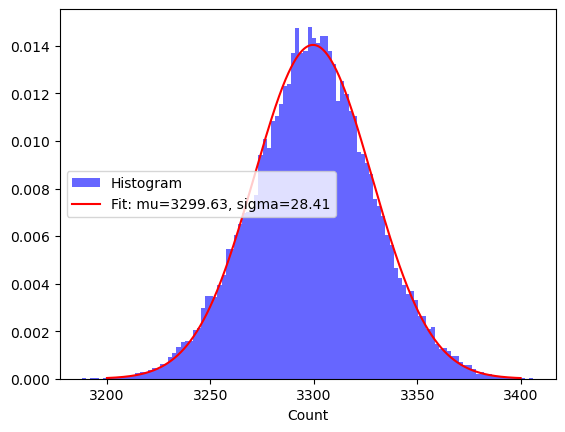

In [120]:
data=peak_search(np.concatenate(ampFault[2]),3000)[0]
bin=110

hist, bins = np.histogram(data, bins=bin, density=True)
width = bins[1] - bins[0]
center = (bins[:-1] + bins[1:]) / 2

plt.hist(data, bins=bin, density=True, alpha=0.6, color='b', label='Histogram')

def fit_function(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

initial_params = [3300, 100]

params, params_covariance = curve_fit(fit_function, center, hist, p0=initial_params)

mu, sigma = params

x = np.linspace(3200, 3400, 10000)
fitted_curve = fit_function(x, mu, sigma)
plt.plot(x, fitted_curve, 'r-', label='Fit: mu={:.2f}, sigma={:.2f}'.format(mu, sigma))

plt.xlabel('Count')
plt.legend()
plt.show()



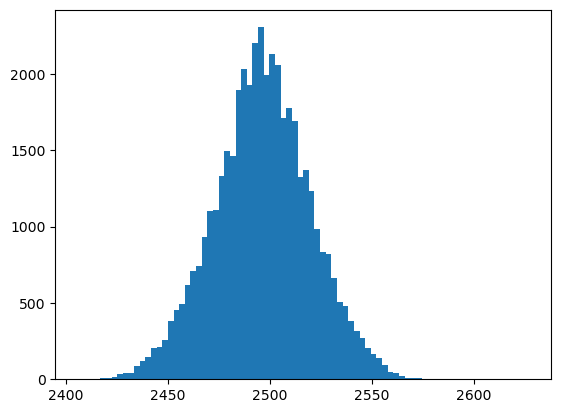

In [121]:
#hist of average of 7 points around peak
plt.hist(peak_search(np.concatenate(ampFault[2]),3000)[1],bins=80)
plt.show()

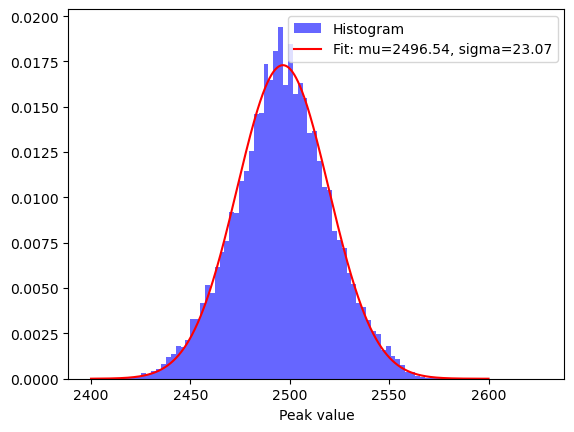

In [396]:
data=peak_search(np.concatenate(ampFault[2]),3000)[1]
bin=90

hist, bins = np.histogram(data, bins=bin, density=True)
width = bins[1] - bins[0]
center = (bins[:-1] + bins[1:]) / 2

plt.hist(data, bins=bin, density=True, alpha=0.6, color='b', label='Histogram')

def fit_function(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

initial_params = [2500, 100]

params, params_covariance = curve_fit(fit_function, center, hist, p0=initial_params)

mu, sigma = params

x = np.linspace(2400, 2600, 10000)
fitted_curve = fit_function(x, mu, sigma)
plt.plot(x, fitted_curve, 'r-', label='Fit: mu={:.2f}, sigma={:.2f}'.format(mu, sigma))

plt.xlabel('Peak value')
plt.legend()
plt.show()



# check linearity and sigma changing amplitude of DAC

In [398]:
def hist_fit(file,threshold,bin,type,mu):
    # Waveforms variables to be filled
    adcLive = { i : []  for i in range(4) }
    ampLive = { i : []  for i in range(4) }  
    adcFault = { i : []  for i in range(4) }
    ampFault = { i : []  for i in range(4) }  
    
    # Open the .dat file
    with fileio.FileReader(files=f'{top_level}/data/20231027/'+file) as fd:
        
        # Loop through the file data
        for header,data in fd.records():
    
            # Convert the numpy array to 16-bit values
            rawData = data[16:].view(np.int16)
            
            # Check for error in frame
            if (header.error>0):
                # Look at record header data
                print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
                print(f"Record size    = {header.size}")
                print(f"Record channel = {header.channel}")
                print(f"Record flags   = {header.flags:#x}")
                print(f"Record error   = {header.error:#x}")
    
            # Check if ADC Live waveform
            elif header.channel < 4:
                adcLive[header.channel-0].append(rawData)
    
            # Check if AMP Live waveform
            elif header.channel < 8:
                ampLive[header.channel-4].append(rawData)        
    
            # Check if ADC Live waveform
            elif header.channel < 12:
                adcFault[header.channel-8].append(rawData)
    
            # Check if AMP Live waveform
            elif header.channel < 16:
                ampFault[header.channel-12].append(rawData)  
            
            # Else undefined stream index
            else:
                print('UNDEFINED DATA STREAM!!!')

    data=peak_search(np.concatenate(ampFault[3]),threshold)[type]
    
    hist, bins = np.histogram(data, bins=bin, density=True)
    width = bins[1] - bins[0]
    center = (bins[:-1] + bins[1:]) / 2
    
    plt.hist(data, bins=bin, density=True, alpha=0.6, color='b', label='Histogram')
    
    def fit_function(x, mu, sigma):
        return norm.pdf(x, mu, sigma)
    
    initial_params = [mu, 100]
    
    params, params_covariance = curve_fit(fit_function, center, hist, p0=initial_params)
    
    mu, sigma = params
    
    x = np.linspace(mu-150, mu+150, 10000)
    fitted_curve = fit_function(x, mu, sigma)
    plt.plot(x, fitted_curve, 'r-', label='Fit: mu={:.2f}, sigma={:.2f}'.format(mu, sigma))
    
    plt.xlabel('Peak value')
    plt.legend()
    plt.show()

    return mu, sigma


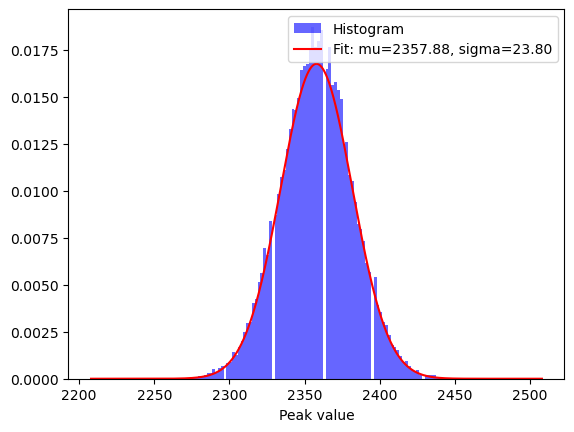

(2357.8779968280137, 23.79921899480227)

In [399]:
hist_fit('data_2000.dat',2200,105,0,2350)

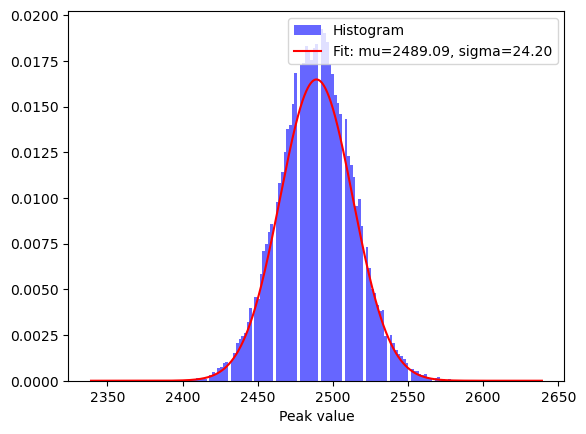

(2489.089268678464, 24.202511190701795)

In [400]:
hist_fit('data_4000.dat',2400,110,0,2500)

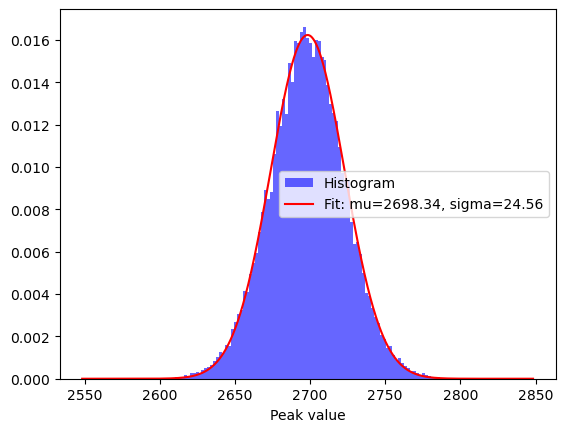

(2698.3378154246043, 24.56388177708104)

In [401]:
hist_fit('data_6000.dat',2600,100,0,2700)

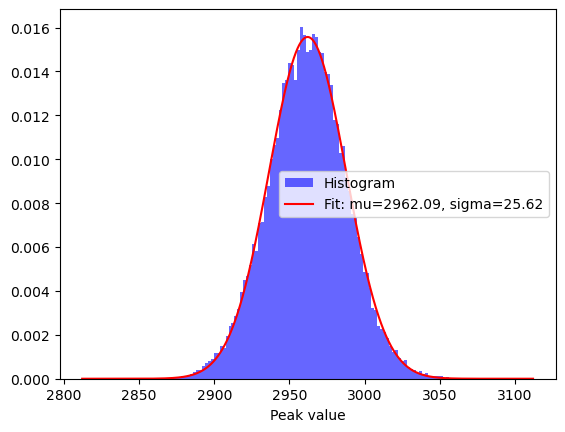

(2962.0918726845325, 25.617999190425532)

In [402]:
hist_fit('data_8000.dat',2800,110,0,2980)

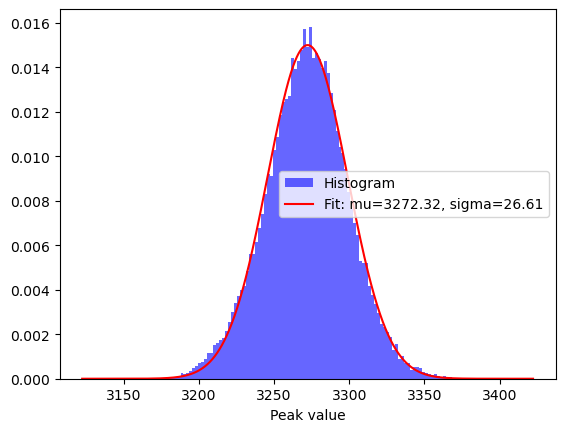

(3272.3175862405737, 26.6051278873139)

In [403]:
hist_fit('data_10000.dat',3100,120,0,3300)

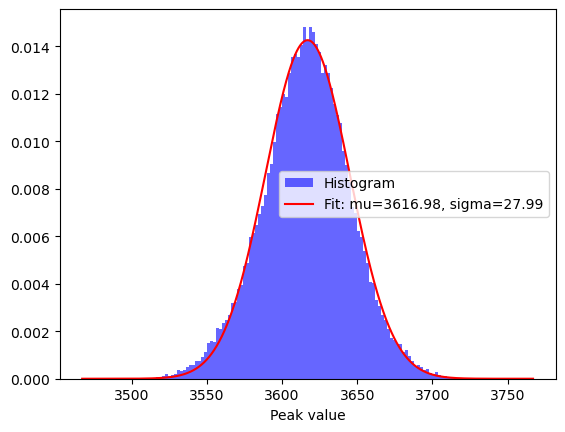

(3616.9824847707923, 27.990794885908038)

In [404]:
hist_fit('data_12000.dat',3500,117,0,3600)

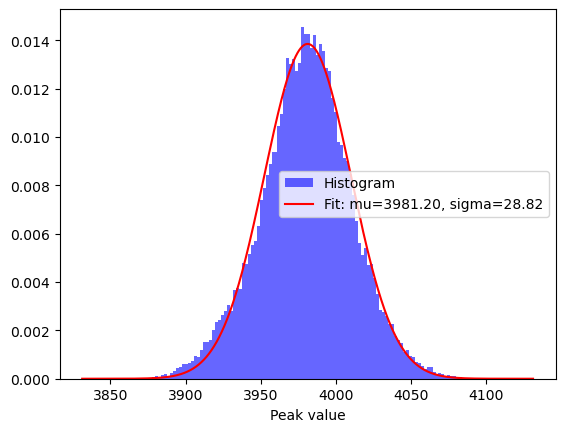

(3981.201316647383, 28.816418890244897)

In [405]:
hist_fit('data_14000.dat',3800,123,0,4000)

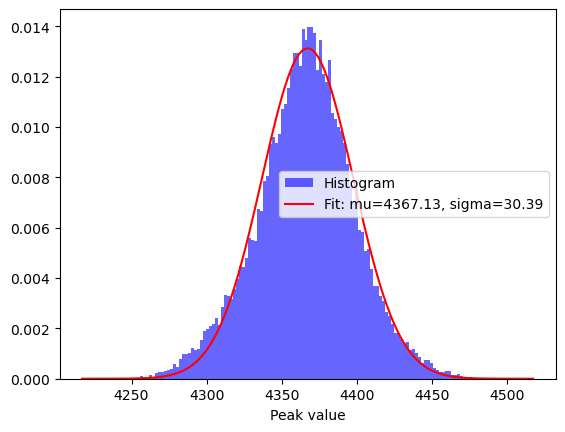

(4367.1345038856125, 30.39093759773828)

In [406]:
hist_fit('data_16000.dat',4200,133,0,4350)

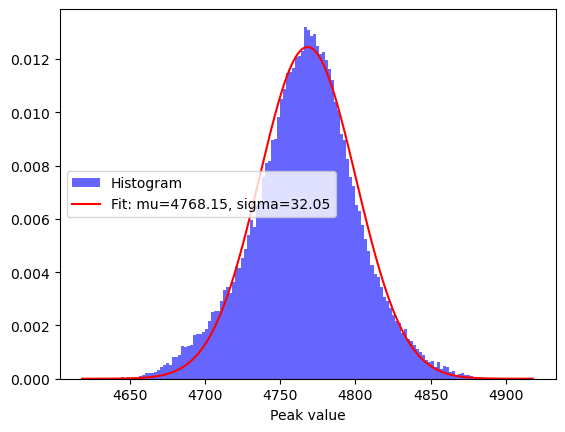

(4768.152889831034, 32.04715322403999)

In [407]:
hist_fit('data_18000.dat',4600,133,0,4800)

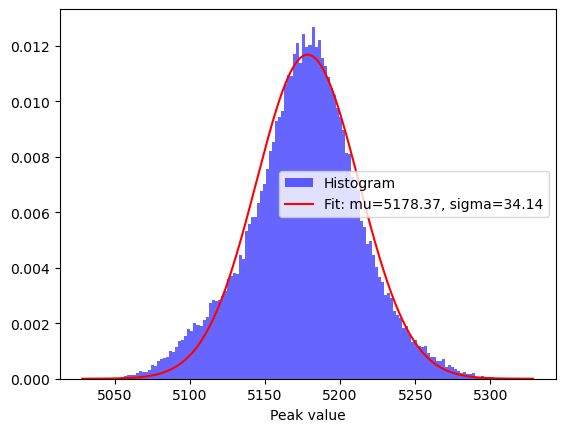

(5178.373944132396, 34.140852524251066)

In [408]:
hist_fit('data_20000.dat',5000,140,0,5200)

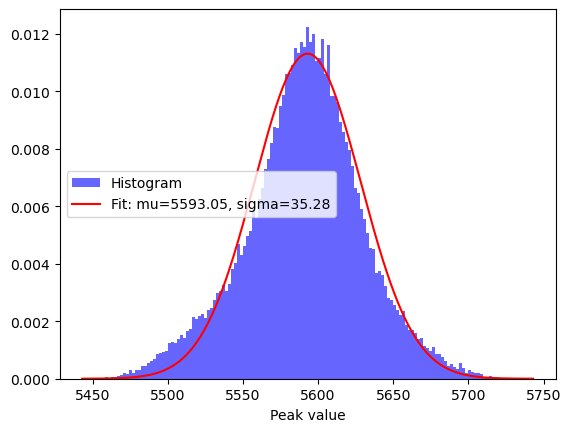

(5593.046538378024, 35.2807493276254)

In [409]:
hist_fit('data_22000.dat',5000,148,0,5600)

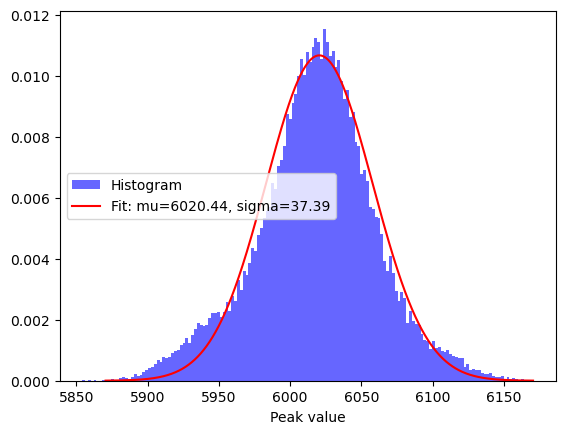

(6020.440840707801, 37.38550367792798)

In [410]:
hist_fit('data_24000.dat',5800,157,0,6000)

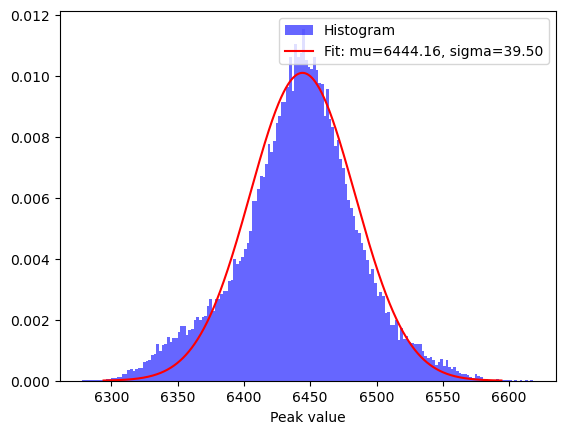

(6444.15908655688, 39.49564648401362)

In [411]:
hist_fit('data_26000.dat',6250,170,0,6400)

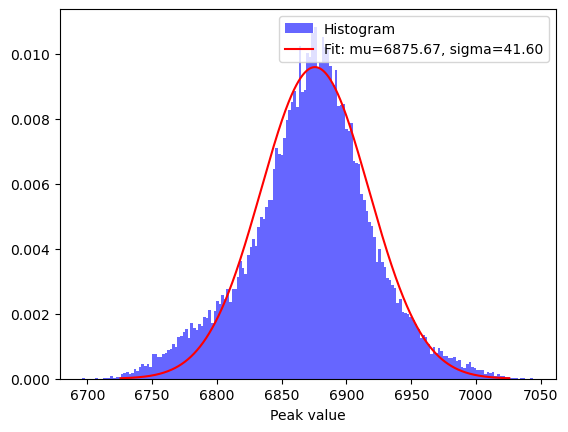

(6875.667368323125, 41.60251687998068)

In [412]:
hist_fit('data_28000.dat',6250,175,0,6900)

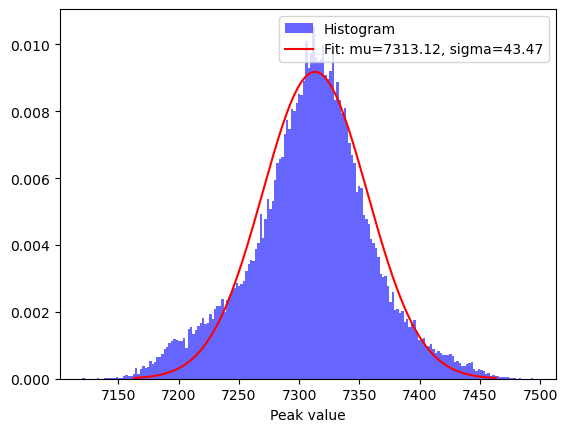

(7313.121450710353, 43.46687368876252)

In [413]:
hist_fit('data_30000.dat',6250,188,0,7300)

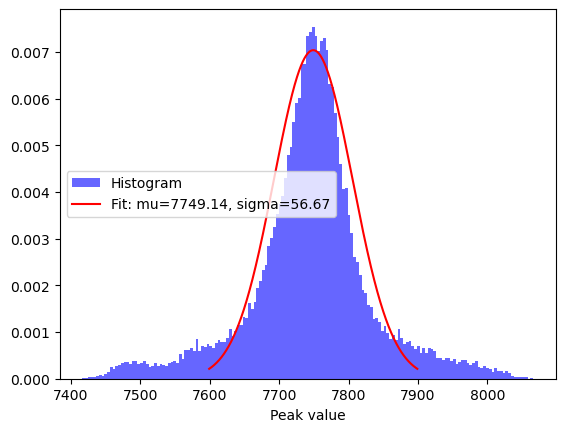

(7749.137594300322, 56.67433311222767)

In [414]:
hist_fit('data_32000.dat',7400,163,0,7700)

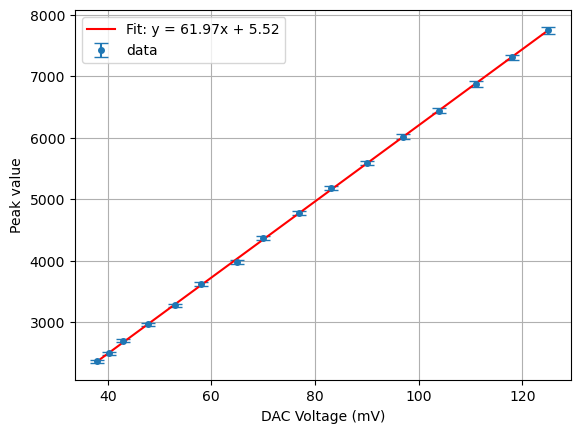

In [415]:
x=np.array([38,40.25,43,47.75,53,58,65,70,77,83,90,97,104,111,118,125])
y=[2357.8779968280137,2489.089268678464, 2698.3378154246043, 2962.0918726845325, 3272.3175862405737, 3616.9824847707923, 3981.201316647383, 4367.1345038856125, 4768.152889831034, 5178.373944132396, 5593.046538378024, 6020.440840707801, 6444.15908655688, 6875.667368323125, 7313.051336132934, 7749.0195260966975]
y_err=[23.79921899480227,24.202511190701795,24.56388177708104,25.61799919042553,26.6051278873139,27.990794885908038,28.816418890244897,30.39093759773828,32.04715322403999,34.140852524251066,35.2807493276254,37.38550367792798,39.49564648401362,41.60251687998068,42.92388569703177,56.17727994057351]
def linear_model(x, a, b):
    return a * x + b

params, covariance = curve_fit(linear_model, x, y, sigma=y_err)

a, b = params

plt.errorbar(x, y, yerr=y_err, capsize=5,fmt='o', label='data',markersize=4)
plt.plot(x, linear_model(x, a, b), label=f'Fit: y = {a:.2f}x + {b:.2f}', color='red')
plt.legend()
plt.xlabel('DAC Voltage (mV)')
plt.ylabel('Peak value')
plt.grid()
plt.show()